In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.kernel_regression import KernelReg
from src.curves import *
from src.link import *
from src.llsir import LLSIR

%load_ext autoreload

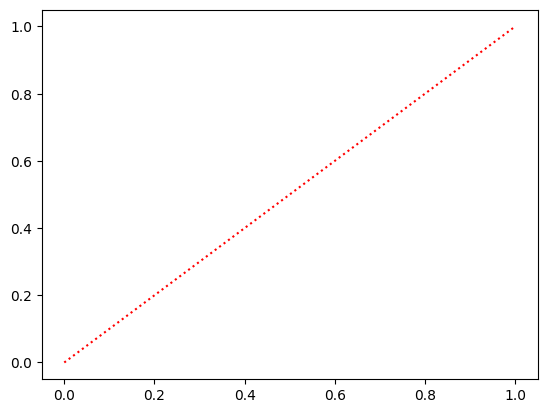

In [12]:

kwargs = {
    "smooth": False,
    "smooth_iters": 5,
    "smooth_alpha": 0.05,
}

curve = gamma(identity, dict=kwargs)

curve.plot(color='red')

Fitting LLSIR at x_0 = [0.8 0.3]


/tmp/ipykernel_37718/1291498965.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], cmap='viridis', s=0.2)


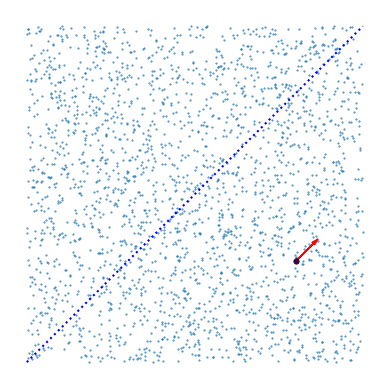

In [13]:
%autoreload 2

# sample uniformly from [0, 1] x [0, 1]
N = 2500
x = np.random.rand(N)
y = np.random.rand(N)
X = np.vstack((x, y)).T

# sample 25 evenly spaced points in [0.1, 0.9]^2 to be test points
x_0s = np.array([[i, j] for i in np.linspace(0.1, 0.9, 6) for j in np.linspace(0.1, 0.9, 6)])
x_0s = np.array([[0.8, 0.3]]) # test point


def id(X):
    return X


llsir = LLSIR(X, curve, id, epsilon=0.1)
betas = []
y_hats = []
y_trues = []
for x_0 in x_0s:
    print(f"Fitting LLSIR at x_0 = {x_0}")
    beta, y_hat, y_true = llsir.fit(x_0)
    betas.append(beta)
    y_hats.append(y_hat)
    y_trues.append(y_true)
betas = np.array(betas)
y_hats = np.array(y_hats)

# test LLSIR
# plot data with color by Y value
plt.scatter(X[:, 0], X[:, 1], cmap='viridis', s=0.2)
# make aspect equal
plt.gca().set_aspect('equal')
curve.plot(color='blue')
plt.axis('off');
for i, x_0i in enumerate(x_0s):
    beta = betas[i]
    # draw beta vector at x_0i
    # plot as arrow
    plt.arrow(x_0i[0], x_0i[1], 0.075 * beta[0], 0.075 * beta[1], head_width=0.01, head_length=0.02, fc='red', ec='red')
plt.scatter(
    x_0s[:, 0], x_0s[:, 1],
    c=y_hats, cmap='viridis',
    s=15, edgecolors='black', linewidths=0.5
)
plt.axis('off');

Running LLSIR with N = 500
Running LLSIR with N = 700
Running LLSIR with N = 900
Running LLSIR with N = 1100
Running LLSIR with N = 1300
Running LLSIR with N = 1500


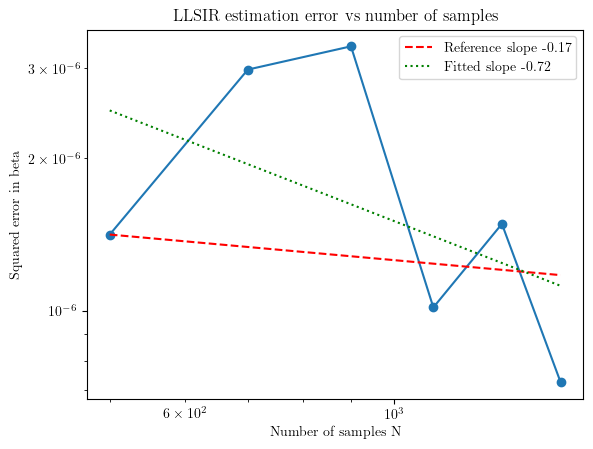

In [ ]:

curve = gamma(identity, dict=kwargs)

Ns = np.arange(500, 1501, 200)
trials = 10
mean_sq_errors = []
var_sq_errors = []
x_0 = np.array([[0.8, 0.3]]) # test point

for N in Ns:
    sq_errors = []
    print(f"Running LLSIR with N = {N}")
    for t in range(trials):
        # sample uniformly from [0, 1] x [0, 1]
        x = np.random.rand(N)
        y = np.random.rand(N)
        X = np.vstack((x, y)).T


        llsir = LLSIR(X, curve, id, epsilon=0.1)
        beta, y_hat, y_true = llsir.fit(x_0[0])
        true_beta = curve.unit_gradient(curve.project(x_0[0])[1])

        sq_error = min(np.linalg.norm(beta - true_beta)**2, np.linalg.norm(beta + true_beta)**2)
        sq_errors.append(sq_error)
    mean_sq_error = np.mean(sq_errors)
    var_sq_error = np.var(sq_errors)
    mean_sq_errors.append(mean_sq_error)
    var_sq_errors.append(var_sq_error)
plt.figure()
# plot log-log of sq_error vs N
plt.loglog(Ns, mean_sq_errors, marker='o')
plt.xlabel('Number of samples N')
plt.ylabel('Squared error in beta')
plt.title('LLSIR estimation error vs number of samples')
# plot reference line of slope -1/(d + 4)
d = x_0.shape[1]
theoretic_slope = -1 / (d + 4)
ref_Ns = np.array([Ns[0], Ns[-1]])
ref_errors = mean_sq_errors[0] * (ref_Ns / Ns[0])**theoretic_slope
plt.loglog(ref_Ns, ref_errors, linestyle='--', color='red', label=f'Reference slope {theoretic_slope:.2f}')
# fit line to data
log_Ns = np.log(Ns)
log_errors = np.log(mean_sq_errors)
coeffs = np.polyfit(log_Ns, log_errors, 1)
fitted_errors = np.exp(np.polyval(coeffs, log_Ns))
plt.loglog(Ns, fitted_errors, linestyle=':', color='green', label=f'Fitted slope {coeffs[0]:.2f}')
plt.legend()
plt.show()


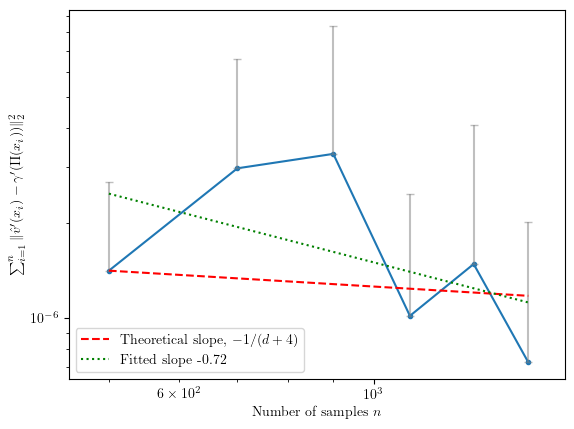

In [70]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # Explicitly set standard LaTeX font
})

plt.figure()
# plot log-log of sq_error vs N
plt.loglog(Ns, mean_sq_errors, marker='o', markersize=3)
plt.xlim(Ns[0] * 0.9, Ns[-1] * 1.1)
# plot variances as error bars
# 1. Calculate the standard deviation
standard_error = np.sqrt(var_sq_errors) 
# 2. Calculate asymmetric log-error bars to keep them looking correct on a log scale
# This prevents the lower bar from trying to hit zero.
lower_error = mean_sq_errors - np.maximum(1e-10, mean_sq_errors - standard_error) # clamp to avoid <= 0
upper_error = standard_error

plt.errorbar(Ns, mean_sq_errors, 
             yerr=[np.zeros_like(upper_error), upper_error], # Only upper bars
             fmt='none', ecolor='gray', alpha=0.5, capsize=3)
plt.xlabel(r'Number of samples $n$')
plt.ylabel(r"$\sum_{i = 1}^n\|\hat{v}'(x_i) - \gamma'(\Pi(x_i))\|_2^2$")
# plot reference line of slope -1/(d + 4)
d = x_0s.shape[1]
theoretic_slope = -1 / (d + 4)
ref_Ns = np.array([Ns[0], Ns[-1]])
ref_errors = mean_sq_errors[0] * (ref_Ns / Ns[0])**theoretic_slope
plt.loglog(ref_Ns, ref_errors, linestyle='--', color='red', label=r'Theoretical slope, $-1/(d+4)$')
# fit line to data
log_Ns = np.log(Ns)
log_errors = np.log(mean_sq_errors)
coeffs = np.polyfit(log_Ns, log_errors, 1)
fitted_errors = np.exp(np.polyval(coeffs, log_Ns))
plt.loglog(Ns, fitted_errors, linestyle=':', color='green', label=f'Fitted slope {coeffs[0]:.2f}')
plt.legend()
plt.show()

In [57]:
print(Ns)
print(var_sq_errors)

[ 500  700  900 1100 1300 1500]
[np.float64(1.6358797635864823e-12), np.float64(1.310328695140165e-11), np.float64(2.5535486521121002e-11), np.float64(2.119663595779728e-12), np.float64(6.6719274042262474e-12), np.float64(1.6411568090152117e-12)]
